# `np_arctan2_f4`

In [1]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/np/overlays/np_arctan2_f4.bit")

L = 2**13

A = allocate(shape=(L,), dtype="f4")
B = allocate(shape=(L,), dtype="f4")
C = allocate(shape=(L,), dtype="f4")

A[:] = np.random.rand(L)
B[:] = np.random.rand(L)
C[:] = np.zeros(L)

## NumPy

In [2]:
def np_arctan2_f4_numpy(x1, x2, out):
    np.arctan2(x1, x2, out)

C[:] = 0
np_arctan2_f4_numpy(A, B, C)
print(C)

[1.2935528  0.97545743 0.83659136 ... 0.74153227 1.0381005  0.8500269 ]


## PYNQ

In [3]:
def np_arctan2_f4_pynq(x1, x2, out):
    overlay.np_arctan2_f4_hw_0.mmio.write(0x10, x1.size)
    overlay.np_arctan2_f4_hw_0.mmio.write(0x0, 0x01)

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_2.recvchannel.transfer(out)
    overlay.axi_dma_2.recvchannel.wait()

C[:] = 0
np_arctan2_f4_pynq(A, B, C)
print(C)

[1.2935528  0.9754575  0.83659136 ... 0.74153227 1.0381005  0.85002697]


## pybind11

In [4]:
%%pybind11 np_arctan2_f4

#include <unistd.h>
#include <fcntl.h>
#include <termios.h>
#include <sys/mman.h>

#define MM2S_DMACR 0x00
#define MM2S_DMACR_RS 0x00000001
#define MM2S_DMACR_Reset 0x00000004
#define MM2S_DMASR 0x04
#define MM2S_DMASR_Halted 0x00000001
#define MM2S_DMASR_Idle 0x00000002
#define MM2S_SA 0x18
#define MM2S_SA_MSB 0x1c
#define MM2S_LENGTH 0x28

#define S2MM_DMACR 0x30
#define S2MM_DMACR_RS 0x00000001
#define S2MM_DMACR_Reset 0x00000004
#define S2MM_DMASR 0x34
#define S2MM_DMASR_Halted 0x00000001
#define S2MM_DMASR_Idle 0x00000002
#define S2MM_DA 0x48
#define S2MM_DA_MSB 0x4c
#define S2MM_LENGTH 0x58

#define printf py::print

#define DMA_0_ADDR 0x40400000
#define dma_0_get(x) DMA_0_VADDR[x >> 2]
#define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

#define DMA_1_ADDR 0x40410000
#define dma_1_get(x) DMA_1_VADDR[x >> 2]
#define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

#define DMA_2_ADDR 0x40420000
#define dma_2_get(x) DMA_2_VADDR[x >> 2]
#define dma_2_set(x, y) DMA_2_VADDR[x >> 2] = y

#define NP_ARCTAN2_F4_ADDR 0x43C00000 
#define np_arctan2_f4_set_stream_len(x) NP_ARCTAN2_F4_VADDR[0x10 >> 2] = x
#define np_arctan2_f4_start() NP_ARCTAN2_F4_VADDR[0x00 >> 2] = 0x00000001

void np_arctan2_f4(unsigned int x1_addr,
                   unsigned int x2_addr,
                   unsigned int out_addr,
                   unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    auto DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    auto DMA_1_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
    );
    auto DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    auto NP_ARCTAN2_F4_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCTAN2_F4_ADDR
    );
    
    np_arctan2_f4_set_stream_len(stream_len);
    np_arctan2_f4_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_1_set(MM2S_SA, x2_addr);
    dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

In [5]:
import np_arctan2_f4 as calc

def np_arctan2_f4_pybind11(x1, x2, out):
    calc.np_arctan2_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

C[:] = 0
np_arctan2_f4_pybind11(A, B, C)
print(C)

[1.2935528  0.9754575  0.83659136 ... 0.74153227 1.0381005  0.85002697]


## CFFI

In [6]:
%%writefile build_np_arctan2_f4_cffi.py

from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef(
    "void np_arctan2_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int stream_len);"
)

ffibuilder.set_source("np_arctan2_f4_cffi",
r"""
    #include <unistd.h>
    #include <fcntl.h>
    #include <termios.h>
    #include <sys/mman.h>

    #define MM2S_DMACR 0x00
    #define MM2S_DMACR_RS 0x00000001
    #define MM2S_DMACR_Reset 0x00000004
    #define MM2S_DMASR 0x04
    #define MM2S_DMASR_Halted 0x00000001
    #define MM2S_DMASR_Idle 0x00000002
    #define MM2S_SA 0x18
    #define MM2S_SA_MSB 0x1c
    #define MM2S_LENGTH 0x28

    #define S2MM_DMACR 0x30
    #define S2MM_DMACR_RS 0x00000001
    #define S2MM_DMACR_Reset 0x00000004
    #define S2MM_DMASR 0x34
    #define S2MM_DMASR_Halted 0x00000001
    #define S2MM_DMASR_Idle 0x00000002
    #define S2MM_DA 0x48
    #define S2MM_DA_MSB 0x4c
    #define S2MM_LENGTH 0x58

    #define printf py::print

    #define DMA_0_ADDR 0x40400000
    #define dma_0_get(x) DMA_0_VADDR[x >> 2]
    #define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

    #define DMA_1_ADDR 0x40410000
    #define dma_1_get(x) DMA_1_VADDR[x >> 2]
    #define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

    #define DMA_2_ADDR 0x40420000
    #define dma_2_get(x) DMA_2_VADDR[x >> 2]
    #define dma_2_set(x, y) DMA_2_VADDR[x >> 2] = y

    #define NP_ARCTAN2_F4_ADDR 0x43C00000 
    #define np_arctan2_f4_set_stream_len(x) NP_ARCTAN2_F4_VADDR[0x10 >> 2] = x
    #define np_arctan2_f4_start() NP_ARCTAN2_F4_VADDR[0x00 >> 2] = 0x00000001

    void np_arctan2_f4(unsigned int x1_addr,
                       unsigned int x2_addr,
                       unsigned int out_addr,
                       unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int *DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int *DMA_1_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
        );
        volatile unsigned int *DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int *NP_ARCTAN2_F4_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCTAN2_F4_ADDR
        );

        np_arctan2_f4_set_stream_len(stream_len);
        np_arctan2_f4_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_1_set(MM2S_SA, x2_addr);
        dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }
"""
)

if __name__ == "__main__":
    import sys
    print(sys.executable)
    ffibuilder.compile(verbose=True)

Overwriting build_np_arctan2_f4_cffi.py


In [7]:
%%bash

/home/xilinx/perf_env/bin/python build_np_arctan2_f4_cffi.py

/home/xilinx/perf_env/bin/python
generating ./np_arctan2_f4_cffi.c
(already up-to-date)
the current directory is '/home/xilinx/jupyter_notebooks/np/build'
running build_ext
building 'np_arctan2_f4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c np_arctan2_f4_cffi.c -o ./np_arctan2_f4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./np_arctan2_f4_cffi.o -o ./np_arctan2_f4_cffi.cpython-37m-arm-linux-gnueabihf.so


In [8]:
from np_arctan2_f4_cffi import lib as calc

def np_arctan2_f4_cffi(x1, x2, out):
    calc.np_arctan2_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

C[:] = 0
np_arctan2_f4_cffi(A, B, C)
print(C)

[1.2935528  0.9754575  0.83659136 ... 0.74153227 1.0381005  0.85002697]


## Timing analysis

kernel = 0, n = 4, t = 7.46656e-05
kernel = 1, n = 4, t = 0.1580620977
kernel = 2, n = 4, t = 0.0003897366
kernel = 3, n = 4, t = 0.0001400259
kernel = 0, n = 8, t = 7.66427e-05
kernel = 1, n = 8, t = 0.15847322280000004
kernel = 2, n = 8, t = 0.0001401963
kernel = 3, n = 8, t = 0.00020413200000000002
kernel = 0, n = 16, t = 8.14735e-05
kernel = 1, n = 16, t = 0.1584217181
kernel = 2, n = 16, t = 0.00013276610000000002
kernel = 3, n = 16, t = 0.0001321808
kernel = 0, n = 32, t = 9.11864e-05
kernel = 1, n = 32, t = 0.15973401450000002
kernel = 2, n = 32, t = 0.00037857570000000005
kernel = 3, n = 32, t = 0.00015288550000000002
kernel = 0, n = 64, t = 0.00010625910000000001
kernel = 1, n = 64, t = 0.1577831299
kernel = 2, n = 64, t = 0.00014379450000000002
kernel = 3, n = 64, t = 0.0001356034
kernel = 0, n = 128, t = 0.00014783420000000002
kernel = 1, n = 128, t = 0.1590317112
kernel = 2, n = 128, t = 0.0001395428
kernel = 3, n = 128, t = 0.00013792560000000002
kernel = 0, n = 256, t = 0

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ numpy             ┃ pynq               ┃ pybind11          ┃ cffi               ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ 4       │ 7.46656e-05       │ 0.1580620977       │ 0.0003897366      │ 0.0001400259       │
│ 8       │ 7.66427e-05       │ 0.158473222800000… │ 0.0001401963      │ 0.000204132000000… │
│ 16      │ 8.14735e-05       │ 0.1584217181       │ 0.00013276610000… │ 0.0001321808       │
│ 32      │ 9.11864e-05       │ 0.159734014500000… │ 0.00037857570000… │ 0.000152885500000… │
│ 64      │ 0.00010625910000… │ 0.1577831299       │ 0.00014379450000… │ 0.0001356034       │
│ 128     │ 0.00014783420000… │ 0.1590317112       │ 0.0001395428      │ 0.000137925600000… │
│ 256     │ 0.00022502370000… │ 0.164060032000000… │ 0.0001487969      │ 0.0002104904       │
│ 512     │ 0.00037972090000… │ 0.166182018800000… │ 0.00040123470000… │ 0.000146664299999… │
│ 1024    │ 0.000757409       │ 0.1649607767       │ 0.000411765       │ 0.0001545065       │
│ 2048    │ 0.00140469110000… │ 0.1586197001       │ 0.0001644034      │ 0.0001566699       │
│ 4096    │ 0.0027544751      │ 0.1582180625       │ 0.0004346597      │ 0.0001821864       │
│ 8192    │ 0.0054254673      │ 0.1579929502       │ 0.00022849500000… │ 0.0002196658       │
│ 16384   │ 0.0107680452      │ 0.1583245724       │ 0.0003377157      │ 0.000431609        │
│ 32768   │ 0.02208901930000… │ 0.1586917041       │ 0.0004918769      │ 0.000558585800000… │
│ 65536   │ 0.0428653753      │ 0.159006527800000… │ 0.00102507510000… │ 0.000885284300000… │
│ 131072  │ 0.0880010408      │ 0.158585738500000… │ 0.00159850610000… │ 0.001493603100000… │
│ 262144  │ 0.171029692       │ 0.1589876923       │ 0.00279620210000… │ 0.0027709984       │
│ 524288  │ 0.3501233924      │ 0.1739857653       │ 0.00539565440000… │ 0.0053903616       │
│ 1048576 │ 0.69674796570000… │ 0.1630119435       │ 0.0106569929      │ 0.0108092907       │
│ 2097152 │ 1.4077975376      │ 0.1623010197       │ 0.0211319704      │ 0.021130497800000… │
└─────────┴───────────────────┴────────────────────┴───────────────────┴────────────────────┘

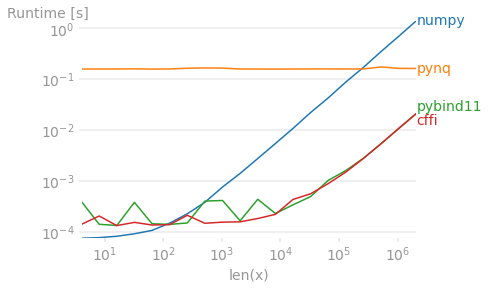

In [9]:
import time
from perfplot._main import PerfplotData

def _setup(n):
    A = allocate(shape=(n,), dtype="f4")
    B = allocate(shape=(n,), dtype="f4")
    C = allocate(shape=(n,), dtype="f4")

    A[:] = np.random.rand(n)
    B[:] = np.random.rand(n)
    C[:] = np.zeros(n)
    
    return A, B, C

kernels = [
    np_arctan2_f4_numpy,
    np_arctan2_f4_pynq,
    np_arctan2_f4_pybind11,
    np_arctan2_f4_cffi,
]

iters = 10
n_range = [2 ** k for k in range(2, 22)] 
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)

labels = ["numpy", "pynq", "pybind11", "cffi"]
xlabel = "len(x)"

for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):        
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        
        print(f"kernel = {j}, n = {n}, t = {timings_s[j,i]}")
        
    for x in data:
        x.freebuffer()
        
p = PerfplotData(
    n_range,
    timings_s,
    None,
    labels,
    xlabel
)

print(p)

p.show()

# `np_arctan2_arcsinh_f4`

In [10]:
from pynq import Overlay, allocate
import numpy as np

overlay = Overlay("/home/xilinx/jupyter_notebooks/np/overlays/np_arctan2_arcsinh_f4.bit")

L = 2**13

A = allocate(shape=(L,), dtype="f4")
B = allocate(shape=(L,), dtype="f4")
C = allocate(shape=(L,), dtype="f4")

A[:] = np.random.rand(L)
B[:] = np.random.rand(L)
C[:] = np.zeros(L)

## PYNQ

In [11]:
def np_arctan2_f4_pynq_combi(x1, x2, out):
    overlay.axis_switch_0.mmio.write(0x40, 0x0)  # M00 -- S00
    overlay.axis_switch_0.mmio.write(0x48, 0x1)  # M02 -- S01
    overlay.axis_switch_0.mmio.write(0x4C, 0x2)  # M03 -- S02
    overlay.axis_switch_0.mmio.write(0x0, 0x2)  # COMMIT
    
    overlay.np_arctan2_f4_hw_0.mmio.write(0x10, x1.size)
    overlay.np_arctan2_f4_hw_0.mmio.write(0x0, 0x01)

    overlay.axi_dma_0.sendchannel.transfer(x1)
    overlay.axi_dma_1.sendchannel.transfer(x2)
    overlay.axi_dma_2.recvchannel.transfer(out)
    overlay.axi_dma_2.recvchannel.wait()

C[:] = 0
np_arctan2_f4_pynq_combi(A, B, C)
print(C)

[1.0572913  1.0085802  0.21771792 ... 1.072208   0.56965643 0.7404159 ]


In [12]:
overlay?

## pybind11

In [13]:
%%pybind11 np_arctan2_arcsinh_f4

#include <unistd.h>
#include <fcntl.h>
#include <termios.h>
#include <sys/mman.h>

#define MM2S_DMACR 0x00
#define MM2S_DMACR_RS 0x00000001
#define MM2S_DMACR_Reset 0x00000004
#define MM2S_DMASR 0x04
#define MM2S_DMASR_Halted 0x00000001
#define MM2S_DMASR_Idle 0x00000002
#define MM2S_SA 0x18
#define MM2S_SA_MSB 0x1c
#define MM2S_LENGTH 0x28

#define S2MM_DMACR 0x30
#define S2MM_DMACR_RS 0x00000001
#define S2MM_DMACR_Reset 0x00000004
#define S2MM_DMASR 0x34
#define S2MM_DMASR_Halted 0x00000001
#define S2MM_DMASR_Idle 0x00000002
#define S2MM_DA 0x48
#define S2MM_DA_MSB 0x4c
#define S2MM_LENGTH 0x58

#define printf py::print

#define DMA_0_ADDR 0x40400000
#define dma_0_get(x) DMA_0_VADDR[x >> 2]
#define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

#define DMA_1_ADDR 0x40410000
#define dma_1_get(x) DMA_1_VADDR[x >> 2]
#define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

#define DMA_2_ADDR 0x40420000
#define dma_2_get(x) DMA_2_VADDR[x >> 2]
#define dma_2_set(x, y) DMA_2_VADDR[x >> 2] = y

#define NP_ARCTAN2_F4_ADDR 0x43C00000
#define np_arctan2_f4_set_stream_len(x) NP_ARCTAN2_F4_VADDR[0x10 >> 2] = x
#define np_arctan2_f4_start() NP_ARCTAN2_F4_VADDR[0x00 >> 2] = 0x00000001

#define NP_ARCSINH_F4_ADDR 0x43C10000
#define np_arcsinh_f4_set_stream_len(x) NP_ARCSINH_F4_VADDR[0x10 >> 2] = x
#define np_arcsinh_f4_start() NP_ARCSINH_F4_VADDR[0x00 >> 2] = 0x00000001

#define AXIS_SWITCH_ADDR 0x43C20000
#define axis_switch_set(x, y) AXIS_SWITCH_VADDR[x >> 2] = y
#define axis_switch_start() AXIS_SWITCH_VADDR[0x00 >> 2] = 0x00000002

void np_arctan2_f4(unsigned int x1_addr,
                   unsigned int x2_addr,
                   unsigned int out_addr,
                   unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    auto DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    auto DMA_1_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
    );
    auto DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    auto NP_ARCTAN2_F4_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCTAN2_F4_ADDR
    );
    auto AXIS_SWITCH_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, AXIS_SWITCH_ADDR
    );

    axis_switch_set(0x40, 0x00);
    axis_switch_set(0x48, 0x01);
    axis_switch_set(0x4c, 0x02);
    axis_switch_start();
        
    np_arctan2_f4_set_stream_len(stream_len);
    np_arctan2_f4_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_1_set(MM2S_SA, x2_addr);
    dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

void np_arcsinh_f4(unsigned int x1_addr,
                   unsigned int out_addr,
                   unsigned int stream_len)
{
    int fd = open("/dev/mem", O_RDWR | O_SYNC);
    auto DMA_0_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
    );
    auto DMA_2_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
    );
    auto NP_ARCSINH_F4_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCSINH_F4_ADDR
    );
    auto AXIS_SWITCH_VADDR = (volatile unsigned int *) mmap(
            NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, AXIS_SWITCH_ADDR
    );

    axis_switch_set(0x44, 0x00);
    axis_switch_set(0x4c, 0x03);
    axis_switch_start();
        
    np_arcsinh_f4_set_stream_len(stream_len);
    np_arcsinh_f4_start();
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);
    
    dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
    dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);
    
    dma_0_set(MM2S_SA, x1_addr);
    dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));
    
    dma_2_set(S2MM_DA, out_addr);
    dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));
    
    while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));
    
    close(fd);
}

In [14]:
import np_arctan2_arcsinh_f4 as calc

def np_arctan2_f4_pybind11(x1, x2, out):
    calc.np_arctan2_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

C[:] = 0
np_arctan2_f4_pybind11(A, B, C)
print(C)

[1.0572913  1.0085802  0.21771792 ... 1.072208   0.56965643 0.7404159 ]


## CFFI

In [15]:
%%writefile build_np_arctan2_arcsinh_f4_cffi.py

from cffi import FFI
ffibuilder = FFI()

ffibuilder.cdef(
    "void np_arctan2_f4(unsigned int x1_addr, unsigned int x2_addr, unsigned int out_addr, unsigned int stream_len);"
    "void np_arcsinh_f4(unsigned int x1_addr, unsigned int out_addr, unsigned int stream_len);"
)

ffibuilder.set_source("np_arctan2_arcsinh_f4_cffi",
r"""
    #include <unistd.h>
    #include <fcntl.h>
    #include <termios.h>
    #include <sys/mman.h>

    #define MM2S_DMACR 0x00
    #define MM2S_DMACR_RS 0x00000001
    #define MM2S_DMACR_Reset 0x00000004
    #define MM2S_DMASR 0x04
    #define MM2S_DMASR_Halted 0x00000001
    #define MM2S_DMASR_Idle 0x00000002
    #define MM2S_SA 0x18
    #define MM2S_SA_MSB 0x1c
    #define MM2S_LENGTH 0x28

    #define S2MM_DMACR 0x30
    #define S2MM_DMACR_RS 0x00000001
    #define S2MM_DMACR_Reset 0x00000004
    #define S2MM_DMASR 0x34
    #define S2MM_DMASR_Halted 0x00000001
    #define S2MM_DMASR_Idle 0x00000002
    #define S2MM_DA 0x48
    #define S2MM_DA_MSB 0x4c
    #define S2MM_LENGTH 0x58

    #define printf py::print

    #define DMA_0_ADDR 0x40400000
    #define dma_0_get(x) DMA_0_VADDR[x >> 2]
    #define dma_0_set(x, y) DMA_0_VADDR[x >> 2] = y

    #define DMA_1_ADDR 0x40410000
    #define dma_1_get(x) DMA_1_VADDR[x >> 2]
    #define dma_1_set(x, y) DMA_1_VADDR[x >> 2] = y

    #define DMA_2_ADDR 0x40420000
    #define dma_2_get(x) DMA_2_VADDR[x >> 2]
    #define dma_2_set(x, y) DMA_2_VADDR[x >> 2] = y

    #define NP_ARCTAN2_F4_ADDR 0x43C00000
    #define np_arctan2_f4_set_stream_len(x) NP_ARCTAN2_F4_VADDR[0x10 >> 2] = x
    #define np_arctan2_f4_start() NP_ARCTAN2_F4_VADDR[0x00 >> 2] = 0x00000001

    #define NP_ARCSINH_F4_ADDR 0x43C10000
    #define np_arcsinh_f4_set_stream_len(x) NP_ARCSINH_F4_VADDR[0x10 >> 2] = x
    #define np_arcsinh_f4_start() NP_ARCSINH_F4_VADDR[0x00 >> 2] = 0x00000001

    #define AXIS_SWITCH_ADDR 0x43C20000
    #define axis_switch_set(x, y) AXIS_SWITCH_VADDR[x >> 2] = y
    #define axis_switch_start() AXIS_SWITCH_VADDR[0x00 >> 2] = 0x00000002

    void np_arctan2_f4(unsigned int x1_addr,
                       unsigned int x2_addr,
                       unsigned int out_addr,
                       unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_1_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_1_ADDR
        );
        volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int * NP_ARCTAN2_F4_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCTAN2_F4_ADDR
        );
        volatile unsigned int * AXIS_SWITCH_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, AXIS_SWITCH_ADDR
        );

        axis_switch_set(0x40, 0x00);
        axis_switch_set(0x48, 0x01);
        axis_switch_set(0x4c, 0x02);
        axis_switch_start();

        np_arctan2_f4_set_stream_len(stream_len);
        np_arctan2_f4_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_1_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_1_set(MM2S_SA, x2_addr);
        dma_1_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }

    void np_arcsinh_f4(unsigned int x1_addr,
                       unsigned int out_addr,
                       unsigned int stream_len)
    {
        int fd = open("/dev/mem", O_RDWR | O_SYNC);
        volatile unsigned int * DMA_0_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_0_ADDR
        );
        volatile unsigned int * DMA_2_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, DMA_2_ADDR
        );
        volatile unsigned int * NP_ARCSINH_F4_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, NP_ARCSINH_F4_ADDR
        );
        volatile unsigned int * AXIS_SWITCH_VADDR = (volatile unsigned int *) mmap(
                NULL, 65535, PROT_READ | PROT_WRITE, MAP_SHARED, fd, AXIS_SWITCH_ADDR
        );

        axis_switch_set(0x44, 0x00);
        axis_switch_set(0x4c, 0x03);
        axis_switch_start();

        np_arcsinh_f4_set_stream_len(stream_len);
        np_arcsinh_f4_start();

        dma_0_set(S2MM_DMACR, S2MM_DMACR_Reset);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_Reset);

        dma_0_set(S2MM_DMACR, S2MM_DMACR_RS);
        dma_2_set(MM2S_DMACR, MM2S_DMACR_RS);

        dma_0_set(MM2S_SA, x1_addr);
        dma_0_set(MM2S_LENGTH, stream_len * sizeof(float));

        dma_2_set(S2MM_DA, out_addr);
        dma_2_set(S2MM_LENGTH, stream_len * sizeof(float));

        while(!(dma_2_get(S2MM_DMASR) & S2MM_DMASR_Idle));

        close(fd);
    }
"""
)

if __name__ == "__main__":
    import sys
    print(sys.executable)
    ffibuilder.compile(verbose=True)

Overwriting build_np_arctan2_arcsinh_f4_cffi.py


In [16]:
%%bash

/home/xilinx/perf_env/bin/python build_np_arctan2_arcsinh_f4_cffi.py

/home/xilinx/perf_env/bin/python
generating ./np_arctan2_arcsinh_f4_cffi.c
(already up-to-date)
the current directory is '/home/xilinx/jupyter_notebooks/np/build'
running build_ext
building 'np_arctan2_arcsinh_f4_cffi' extension
arm-linux-gnueabihf-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/xilinx/perf_env/include -I/usr/include/python3.7m -c np_arctan2_arcsinh_f4_cffi.c -o ./np_arctan2_arcsinh_f4_cffi.o
arm-linux-gnueabihf-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fdebug-prefix-map=/build/python3.7-2QTFw6/python3.7-3.7.0~b3=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 ./np_arctan2_arcsinh_f4_cffi.o -o ./np_arctan2_arcsinh_f4_cffi.cpython-37m-arm-linux-gnueabihf

In [17]:
from np_arctan2_arcsinh_f4_cffi import lib as calc

def np_arctan2_f4_cffi(x1, x2, out):
    calc.np_arctan2_f4(x1.physical_address, x2.physical_address, out.physical_address, x1.size)

C[:] = 0
np_arctan2_f4_cffi(A, B, C)
print(C)

[1.0572913  1.0085802  0.21771792 ... 1.072208   0.56965643 0.7404159 ]


## Timing analysis

kernel = 0, n = 4, t = 0.18747259140000003
kernel = 1, n = 4, t = 0.0004068963
kernel = 2, n = 4, t = 0.00016414400000000002
kernel = 0, n = 8, t = 0.1890408526
kernel = 1, n = 8, t = 0.00015273079999999998
kernel = 2, n = 8, t = 0.00015887600000000002
kernel = 0, n = 16, t = 0.18478796960000002
kernel = 1, n = 16, t = 0.0004008286
kernel = 2, n = 16, t = 0.0001743975
kernel = 0, n = 32, t = 0.1847554825
kernel = 1, n = 32, t = 0.0001614524
kernel = 2, n = 32, t = 0.0001662864
kernel = 0, n = 64, t = 0.1848299059
kernel = 1, n = 64, t = 0.0004025068
kernel = 2, n = 64, t = 0.0001747154
kernel = 0, n = 128, t = 0.1854971671
kernel = 1, n = 128, t = 0.0001680282
kernel = 2, n = 128, t = 0.0001588273
kernel = 0, n = 256, t = 0.19978676090000003
kernel = 1, n = 256, t = 0.00040137170000000005
kernel = 2, n = 256, t = 0.0001906348
kernel = 0, n = 512, t = 0.1852266653
kernel = 1, n = 512, t = 0.00041268120000000004
kernel = 2, n = 512, t = 0.00018431600000000002
kernel = 0, n = 1024, t = 0.

┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n       ┃ pynq_combi          ┃ pybind11_combi         ┃ cffi_combi             ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 4       │ 0.18747259140000003 │ 0.0004068963           │ 0.00016414400000000002 │
│ 8       │ 0.1890408526        │ 0.00015273079999999998 │ 0.00015887600000000002 │
│ 16      │ 0.18478796960000002 │ 0.0004008286           │ 0.0001743975           │
│ 32      │ 0.1847554825        │ 0.0001614524           │ 0.0001662864           │
│ 64      │ 0.1848299059        │ 0.0004025068           │ 0.0001747154           │
│ 128     │ 0.1854971671        │ 0.0001680282           │ 0.0001588273           │
│ 256     │ 0.19978676090000003 │ 0.00040137170000000005 │ 0.0001906348           │
│ 512     │ 0.1852266653        │ 0.00041268120000000004 │ 0.00018431600000000002 │
│ 1024    │ 0.1851136732        │ 0.0001904495           │ 0.0001774464           │
│ 2048    │ 0.18542204380000002 │ 0.00046322990000000004 │ 0.0002002933           │
│ 4096    │ 0.1853207487        │ 0.0004712819000000001  │ 0.00021839760000000002 │
│ 8192    │ 0.18716016680000003 │ 0.0004965437           │ 0.000252184            │
│ 16384   │ 0.1876156471        │ 0.0005922093000000001  │ 0.00032538590000000007 │
│ 32768   │ 0.1861081511        │ 0.0005269489           │ 0.0006046630000000001  │
│ 65536   │ 0.1857061521        │ 0.0008421542           │ 0.0009082773000000001  │
│ 131072  │ 0.18569157690000002 │ 0.0015041144           │ 0.0015017738000000001  │
│ 262144  │ 0.18689935230000002 │ 0.0028265274000000003  │ 0.0027936566000000005  │
│ 524288  │ 0.19564201230000003 │ 0.0055121661           │ 0.0054521387           │
│ 1048576 │ 0.1867095434        │ 0.010664598800000001   │ 0.010678274400000002   │
│ 2097152 │ 0.18845646740000002 │ 0.021166112600000002   │ 0.0211564362           │
└─────────┴─────────────────────┴────────────────────────┴────────────────────────┘

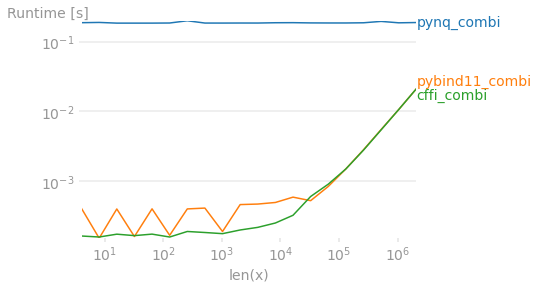

In [18]:
import time
from perfplot._main import PerfplotData

def _setup(n):
    A = allocate(shape=(n,), dtype="f4")
    B = allocate(shape=(n,), dtype="f4")
    C = allocate(shape=(n,), dtype="f4")

    A[:] = np.random.rand(n)
    B[:] = np.random.rand(n)
    C[:] = np.zeros(n)
    
    return A, B, C

kernels = [
    np_arctan2_f4_pynq,
    np_arctan2_f4_pybind11,
    np_arctan2_f4_cffi,
]

iters = 10
n_range = [2 ** k for k in range(2, 22)] 
timings_s = np.empty((len(kernels), len(n_range)), dtype=float)

labels = ["pynq_combi", "pybind11_combi", "cffi_combi"]
xlabel = "len(x)"

for i, n in enumerate(n_range):
    t0_ns = time.time_ns()
    for _ in range(10):
        pass
    t1_ns = time.time_ns()
    
    loop_overhead_ns = t1_ns - t0_ns
    
    data = _setup(n)

    for j, kernel in enumerate(kernels):        
        t0_ns = time.time_ns()
        for _ in range(iters):
            kernel(*data)
        t1_ns = time.time_ns()
        
        timings_s[j,i] = 1e-9 * ((t1_ns - t0_ns - loop_overhead_ns) / iters)
        
        print(f"kernel = {j}, n = {n}, t = {timings_s[j,i]}")
        
    for x in data:
        x.freebuffer()
        
q = PerfplotData(
    n_range,
    timings_s,
    None,
    labels,
    xlabel
)

print(q)

q.show()

# Timing analysis overview

┏━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ n       ┃ numpy     ┃ pynq      ┃ pybind11  ┃ cffi      ┃ pynq_co… ┃ pybind11… ┃ cffi_co… ┃
┡━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ 4       │ 7.46656e… │ 0.158062… │ 0.000389… │ 0.000140… │ 0.18747… │ 0.000406… │ 0.00016… │
│ 8       │ 7.66427e… │ 0.158473… │ 0.000140… │ 0.000204… │ 0.18904… │ 0.000152… │ 0.00015… │
│ 16      │ 8.14735e… │ 0.158421… │ 0.000132… │ 0.000132… │ 0.18478… │ 0.000400… │ 0.00017… │
│ 32      │ 9.11864e… │ 0.159734… │ 0.000378… │ 0.000152… │ 0.18475… │ 0.000161… │ 0.00016… │
│ 64      │ 0.000106… │ 0.157783… │ 0.000143… │ 0.000135… │ 0.18482… │ 0.000402… │ 0.00017… │
│ 128     │ 0.000147… │ 0.159031… │ 0.000139… │ 0.000137… │ 0.18549… │ 0.000168… │ 0.00015… │
│ 256     │ 0.000225… │ 0.164060… │ 0.000148… │ 0.000210… │ 0.19978… │ 0.000401… │ 0.00019… │
│ 512     │ 0.000379… │ 0.166182… │ 0.000401… │ 0.000146… │ 0.18522… │ 0.000412… │ 0.00018… │
│ 1024    │ 0.000757… │ 0.164960… │ 0.000411… │ 0.000154… │ 0.18511… │ 0.000190… │ 0.00017… │
│ 2048    │ 0.001404… │ 0.158619… │ 0.000164… │ 0.000156… │ 0.18542… │ 0.000463… │ 0.00020… │
│ 4096    │ 0.002754… │ 0.158218… │ 0.000434… │ 0.000182… │ 0.18532… │ 0.000471… │ 0.00021… │
│ 8192    │ 0.005425… │ 0.157992… │ 0.000228… │ 0.000219… │ 0.18716… │ 0.000496… │ 0.00025… │
│ 16384   │ 0.010768… │ 0.158324… │ 0.000337… │ 0.000431… │ 0.18761… │ 0.000592… │ 0.00032… │
│ 32768   │ 0.022089… │ 0.158691… │ 0.000491… │ 0.000558… │ 0.18610… │ 0.000526… │ 0.00060… │
│ 65536   │ 0.042865… │ 0.159006… │ 0.001025… │ 0.000885… │ 0.18570… │ 0.000842… │ 0.00090… │
│ 131072  │ 0.088001… │ 0.158585… │ 0.001598… │ 0.001493… │ 0.18569… │ 0.001504… │ 0.00150… │
│ 262144  │ 0.171029… │ 0.158987… │ 0.002796… │ 0.002770… │ 0.18689… │ 0.002826… │ 0.00279… │
│ 524288  │ 0.350123… │ 0.173985… │ 0.005395… │ 0.005390… │ 0.19564… │ 0.005512… │ 0.00545… │
│ 1048576 │ 0.696747… │ 0.163011… │ 0.010656… │ 0.010809… │ 0.18670… │ 0.010664… │ 0.01067… │
│ 2097152 │ 1.407797… │ 0.162301… │ 0.021131… │ 0.021130… │ 0.18845… │ 0.021166… │ 0.02115… │
└─────────┴───────────┴───────────┴───────────┴───────────┴──────────┴───────────┴──────────┘

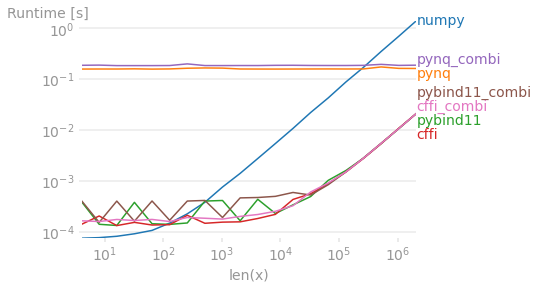

In [22]:
p.timings_s = np.concatenate((p.timings_s, q.timings_s))
p.labels += q.labels

print(p)
p.show()